In [86]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

class EMNISTDataset(Dataset):
    
    intToStrDict = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
    NUM_CLASSES = 26
    
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)
        self.labels = torch.Tensor(self.data.iloc[:, 0].values).to(torch.int16)
        self.images = torch.Tensor(self.data.iloc[:, 1:].values.reshape(-1, 1, 28, 28, order='A')).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label


def displayImageGrid(images: list, H: int, W: int=0, labels: list=None, figsize=None, title=''):
    """
    Display list of images in a grid (H, W) without boundaries. The images MUST be the same size or this will probably look weird.

    Arguments:
        images: List of numpy arrays representing the images. The images should be the same size
        H: Number of rows.
        W: Number of columns.
        figsize: The figure size of the output plot
        title: A title for the plot
    """
    
    numImages = len(images)
    
    # If no width is defined, we assume a single row of images
    if W == 0:
        W = numImages
    
    if numImages < H * W:
        raise ValueError(f"Number of images ({len(images)}) is smaller than given grid size!")
    
    # Shrink figure size if plotting lots of images
    if figsize is None:
        fig = plt.figure(figsize=(W/5, H/5))
    else:
        fig = plt.figure(figsize=figsize)

    for i in range(H * W):
        img = images[i]
        label = labels[i] if labels is not None else ''
            
        ax = fig.add_subplot(H, W, i+1)
        ax.imshow(img, cmap='gray')

        # Remove axis details
        ax.axis('off')
        
        # Adjust the position of the axis for each image slightly to make room for the label
        # ax.set_position([i%W/W, 1-(i//W+1)/H + 0.2, 1/W, 1/H - 0.05])
        
        # Adjust the position of the axis for each image to make more room for the label
        ax.set_position([i%W/W, 1-(i//W+1)/H + 0.05, 1/W, 1/H - 2])
        
        # Add label below the image
        ax.set_title(label, fontsize=10, pad=6, y=-0.25) # pad adds space between the image and the label
        
        # Add label below the image
        # ax.set_title(label, fontsize=10, y=-0.2)
        

    plt.suptitle(title)
    plt.subplots_adjust(wspace=0, hspace=0, top=0.95)
    plt.show()



def visualizeSamples(dataLoader: DataLoader, BATCH_SIZE=64, H=8, W=8, title=''):
    
    features, labels = next(iter(dataLoader))
    features: torch.Tensor
    labels: torch.Tensor

    # Do the tensor shuffle
    featuresArray = features.numpy().transpose(2, 3, 1, 0)
    labelsList = list(labels.numpy())
    labelsList = [EMNISTDataset.intToStrDict[l] for l in labelsList]

    displayImageGrid([featuresArray[..., idx] for idx in range(BATCH_SIZE)], H=H, W=W, figsize=(10, 12), title=title, labels=labelsList)
    


In [87]:
# Keep this to visualize raw .csv data if needed
# num_columns = 785
# # Create column names
# columns = ['label'] + list(range(1, num_columns))
# # Read the training and testing datasets
# ds_train = pd.read_csv("Data\EMNIST\EMNIST\emnist-letters-train.csv", header=None)
# ds_test = pd.read_csv("Data\EMNIST\EMNIST\emnist-letters-test.csv", header=None)
# # Assign column names to the DataFrames
# ds_train.columns = columns
# ds_test.columns = columns
# # Reset index
# ds_train = ds_train.reset_index(drop=True)
# ds_test = ds_test.reset_index(drop=True)
# # Extract features and labels
# x_train = ds_train.drop(['label'], axis=1)
# y_train = ds_train['label']
# x_test = ds_test.drop(['label'], axis=1)
# y_test = ds_test['label']
# # Display the first few rows of the DataFrame
# print(ds_train.head())
# print(ds_test.head())
# print(sorted(ds_train['label'].unique()))

In [89]:
trainset = EMNISTDataset("Data\EMNIST\emnist-letters-train.csv")
testset = EMNISTDataset("Data\EMNIST\emnist-letters-test.csv")

<class 'torch.Tensor'>


<class 'torch.Tensor'>


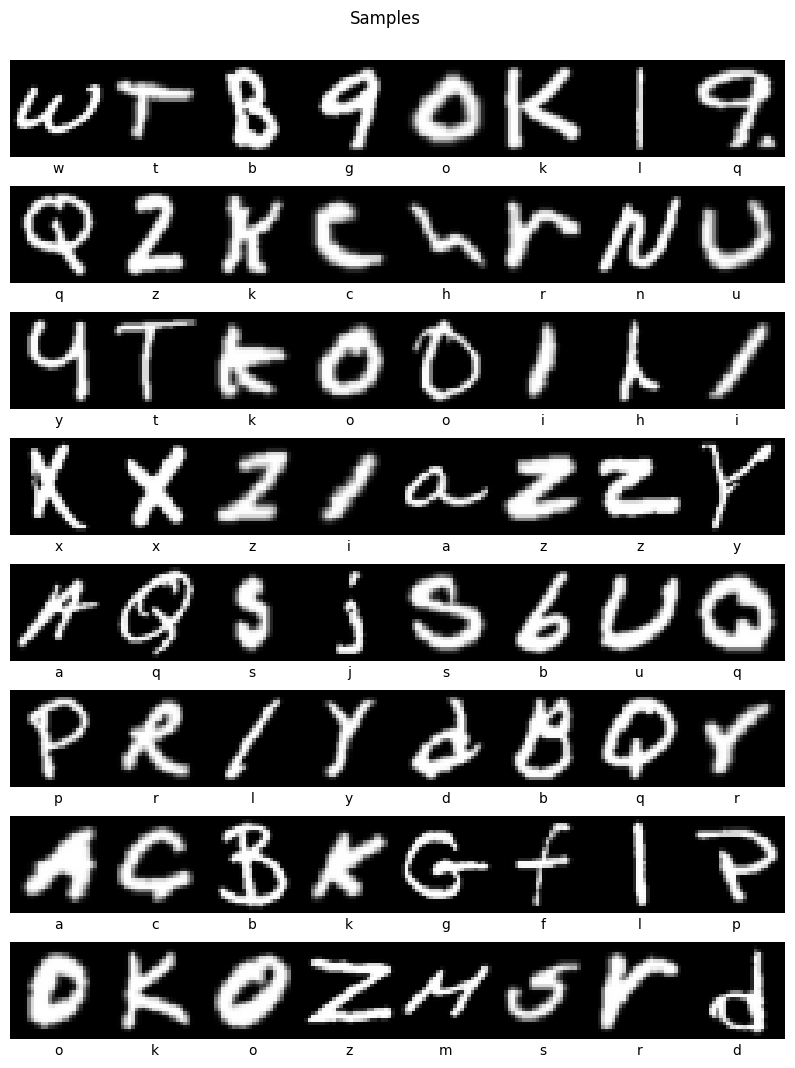

In [90]:
print(type(trainset.images))

BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

features, labels = next(iter(trainloader))
features = features.clone().detach()

visualizeSamples(trainloader, title='Samples')

# Perform PCA and clustering to isolate handwriting "styles"

[17864 21852 22073 27011]


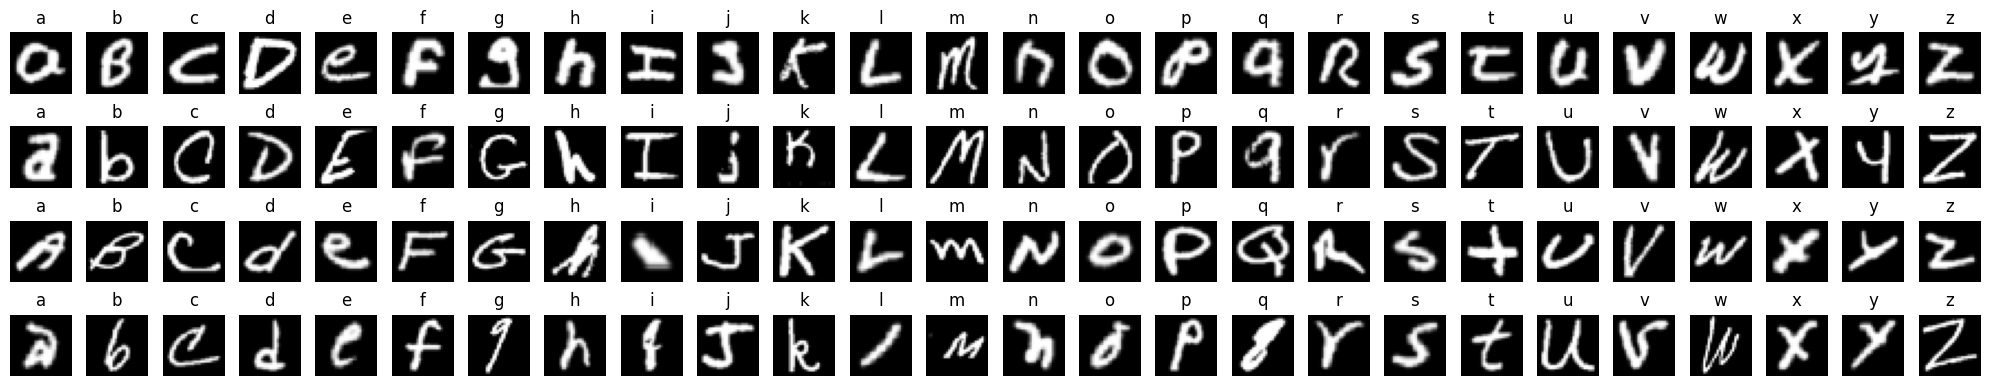

In [104]:
# Flatten the images
flatImages = trainset.images.reshape(len(trainset), -1).numpy()

# Perform PCA
pca = PCA(n_components=500)  # Choose the number of components based on your requirements
PCAFeatures = pca.fit_transform(flatImages)

# Cluster the data points
numClusters = 4  # Choose the number of clusters based on your requirements
kmeans = KMeans(n_clusters=numClusters)
clusterLabels = kmeans.fit_predict(PCAFeatures)


minLettersPerCluster = 1000  # Adjust this value based on your requirements

# Count the number of letters in each cluster
clusterCounts = np.bincount(clusterLabels)
print(clusterCounts)

# Identify clusters with insufficient letters
smallClusters = np.where(clusterCounts < minLettersPerCluster)[0]

# Merge small clusters with the nearest larger clusters
for smallCluster in smallClusters:
    # Find the nearest larger cluster
    nearestCluster = None
    minDistance = float('inf')
    for cluster in range(numClusters):
        if cluster != smallCluster and clusterCounts[cluster] >= minLettersPerCluster:
            distance = np.linalg.norm(kmeans.cluster_centers_[smallCluster] - kmeans.cluster_centers_[cluster])
            if distance < minDistance:
                minDistance = distance
                nearestCluster = cluster
    
    # Merge the small cluster with the nearest larger cluster
    clusterLabels[clusterLabels == smallCluster] = nearestCluster


# Visualize the clusters
fig, axs = plt.subplots(numClusters, 26, figsize=(20, numClusters))
for i in range(numClusters):
    clusterIndices = np.where(clusterLabels == i)[0]
    for j in range(26):
        letterIndices = np.where(trainset.labels[clusterIndices] == j+1)[0]
        if len(letterIndices) > 0:
            imageIndex = clusterIndices[np.random.choice(letterIndices)]
            axs[i, j].imshow(trainset.images[imageIndex].squeeze(), cmap='gray')
            axs[i, j].set_title(trainset.intToStrDict[j+1])
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Look at these

'''
https://wandb.ai/capecape/train_sd/reports/How-To-Train-a-Conditional-Diffusion-Model-From-Scratch--VmlldzoyNzIzNTQ1
https://github.com/TeaPearce/Conditional_Diffusion_MNIST
'''